# Problem 12.2

**Integrated Energy Grids**

**Problem 12.1. Synthetic methanol production in an energy island.**

**In this problem, we want to build a stylized mode of methanol production in an energy island. Assume an offshore generator, an electrolyzer, a Direct Air Capture (DAC) unit ,and a methanolisation unit with the cost in Table. For the offshore generator, assume the [capacity factors for Denmark](https://zenodo.org/record/3253876#.XSiVOEdS8l0).**


**An annual methanol demand of 200 GWh must be delivered and, for the sake of simplicity, assume that the island includes a hydrogen storage, a CO$_2$, and a methanol storage with no cost. The electrolyzer efficiency is assumed to be 62\%. The methanolisation plant requires hydrogen, CO$_2$ and electricity as inputs. It produces 0.8787 MWh of methanol per MWh of hydrogen, 4.0321 MWh of methanol per tonne of CO$_2$, and 3.6907 MWh of methanol per MWh of electricity.** 


**The DAC unit requires  MWh of electricity and MWh of heat to capture 1 tonne of CO$_2$. Heat is assumed to be provided by a heat pump with a constant coefficient of performance (COP) of 3.**

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install `pandas` and `numpy` by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pandas pypsa
```
:::

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pypsa

## Prerequisites: handling technology data and costs

We maintain a database (https://github.com/PyPSA/technology-data) which collects assumptions and projections for energy system technologies (such as costs, efficiencies, lifetimes, etc.) for given years, which we can load into a `pandas.DataFrame`. This requires some pre-processing to load (e.g. converting units, setting defaults, re-arranging dimensions):

In [2]:
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])

In [3]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

Let's also write a small utility function that calculates the **annuity** to annualise investment costs. The formula is

$$
a(r, n) = \frac{r}{1-(1+r)^{-n}}
$$
where $r$ is the discount rate and $n$ is the lifetime.

In [4]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [5]:
annuity(0.07, 20)

0.09439292574325567

Based on this, we can calculate the marginal generation costs (€/MWh):

In [6]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

and the annualised investment costs (`capital_cost` in PyPSA terms, €/MW/a):

In [7]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)

In [8]:
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

We can now read the capital and marginal cost of onffhore wind and electrolysis

In [9]:
costs.at["offwind", "capital_cost"] #EUR/MW/a

174556.22307975945

In [10]:
costs.at["electrolysis", "capital_cost"] #EUR/MW/a

188715.7758309984

## Retrieving time series data

In this example, wind data from [https://zenodo.org/record/3253876#.XSiVOEdS8l0](https://zenodo.org/record/3253876#.XSiVOEdS8l0) and solar PV data from [https://zenodo.org/record/2613651#.X0kbhDVS-uV](https://zenodo.org/record/3253876#.XSiVOEdS8l0) is used. The data is downloaded in csv format and saved in the 'data' folder.
The Pandas package is used as a convenient way of managing the datasets.

For convenience, the column including date information is converted into Datetime and set as index

In [11]:
data_offwind = pd.read_csv('data/offshore_wind_1979-2017.csv',sep=';')
data_offwind.index = pd.DatetimeIndex(data_offwind['utc_time'])


The data format can now be analyzed using the .head() function to show the first lines of the data set

In [12]:
data_offwind.head()

,utc_time,BEL,DEU,DNK,GBR,NLD,SWE,FIN,FRA,IRL,NOR
utc_time,,,,,,,,,,,
1979-01-01 00:00:00+00:00,1979-01-01T00:00:00Z,0.513,0.875,0.986,0.522,0.484,0.712,0.470,0.296,0.676,0.232
1979-01-01 01:00:00+00:00,1979-01-01T01:00:00Z,0.367,0.861,0.985,0.549,0.322,0.713,0.384,0.331,0.584,0.180
1979-01-01 02:00:00+00:00,1979-01-01T02:00:00Z,0.372,0.845,0.978,0.551,0.267,0.711,0.321,0.343,0.466,0.161
1979-01-01 03:00:00+00:00,1979-01-01T03:00:00Z,0.351,0.819,0.968,0.498,0.274,0.709,0.271,0.223,0.389,0.163
1979-01-01 04:00:00+00:00,1979-01-01T04:00:00Z,0.338,0.787,0.957,0.457,0.274,0.708,0.224,0.189,0.270,0.168


We will use timeseries for Denmark in this excercise

In [13]:
country = 'DNK'

### Join capacity and dispatch optimization

For building the model, we start again by initialising an empty network, adding the snapshots, the electricity and the hydrogen bus.

In [14]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

n.add("Bus", "electricity")
n.add("Bus", "hydrogen")
n.add("Bus", "methanol")
n.add("Bus", "heat")
n.add("Bus", "co2")
n.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

Next, we add the methanol demand time series to the model. 
We add a "free" store in the hydrogen, methanol and CO2 buses. 

In [15]:
annual_methanol_demand = 200000 #MWh
methanol_demand = annual_methanol_demand/8760*np.ones(8760)
n.add("Load",
      "methanol demand",
      bus = "methanol",
      p_set=methanol_demand)

n.add("Store",
      "hydrogen store",
      bus = "hydrogen",
      e_nom_extendable=True,
      e_cyclic=True)  # cyclic state of charge

n.add("Store",
      "methanol store",
      bus = "methanol",
      e_nom_extendable=True,
      e_cyclic=True)  

n.add("Store",
      "co2 store",
      bus = "co2",
      e_nom_extendable=True,
      e_cyclic=True)  


Index(['co2 store'], dtype='object')

Let's have a check whether the data was read-in correctly.

<Axes: xlabel='snapshot', ylabel='MW'>

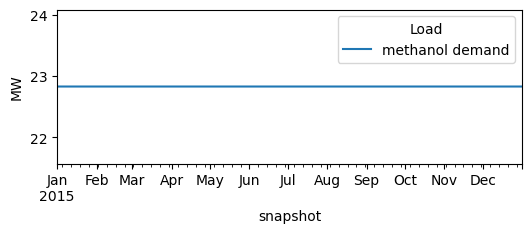

In [16]:
n.loads_t.p_set.plot(figsize=(6, 2), ylabel="MW")

We add now the offshore wind generator and set up the capacity to be extendable so that it can be optimized. We need to indicate the capacity factor or maximum power per unit 'p_max_pu'

In [17]:
CF_wind = data_offwind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
n.add(
        "Generator",
        "offwind",
        bus="electricity",
        p_max_pu=CF_wind.values,
        capital_cost=costs.at["offwind", "capital_cost"],
        marginal_cost=costs.at["offwind", "marginal_cost"],
        p_nom_extendable=True,
    )


Index(['offwind'], dtype='object')

So let's make sure the capacity factors are read-in correctly.

<Axes: xlabel='snapshot', ylabel='CF'>

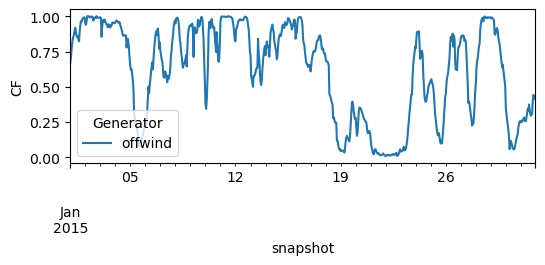

In [18]:
n.generators_t.p_max_pu.loc["2015-01"].plot(figsize=(6, 2), ylabel="CF")

We add the electrolyzer. 

In [19]:
n.add(
    "Link",
    "electrolysis",
    bus0="electricity",
    bus1="hydrogen",
    p_nom_extendable=True,
    efficiency=costs.at["electrolysis", "efficiency"],
    capital_cost=costs.at["electrolysis", "capital_cost"] #EUR/MW/a, 
)

Index(['electrolysis'], dtype='object')

We add the methanolisation unit.

In [20]:
MWh_MeOH_per_MWh_H2 = 0.8787
MWh_MeOH_per_tCO2 = 4.0321
MWh_MeOH_per_MWh_e = 3.6907

n.add(
      "Link",
      "methanolisation",
       bus0="hydrogen",
       bus1="methanol",
       bus2="electricity",
       bus3="co2",
       p_nom_extendable=True,
       capital_cost=costs.at["methanolisation", "capital_cost"]* MWh_MeOH_per_MWh_H2,  # EUR/MW_H2/a
        #marginal_cost=costs.at["methanolisation", "VOM"]*options["MWh_MeOH_per_MWh_H2"],
       efficiency=MWh_MeOH_per_MWh_H2,
       efficiency2=-MWh_MeOH_per_MWh_H2/ MWh_MeOH_per_MWh_e,
       efficiency3=-MWh_MeOH_per_MWh_H2/ MWh_MeOH_per_tCO2,
    )

Index(['methanolisation'], dtype='object')

We add the direct air capture (DAC) unit. Since DAC needs heat as input, we assume that this is provided using a heat pump. 

In [21]:
electricity_input = (
        costs.at["direct air capture", "electricity-input"]
        + costs.at["direct air capture", "compression-electricity-input"])  # MWh_el / tCO2
heat_input = (
        costs.at["direct air capture", "heat-input"]
        - costs.at["direct air capture", "compression-heat-output"])  # MWh_th / tCO2

n.add("Link",
      "DAC",
       bus0="electricity",
       bus1="heat",
       bus2="co2",
       capital_cost=costs.at["direct air capture", "capital_cost"] / electricity_input,
       efficiency=-heat_input / electricity_input,
       efficiency32=1 / electricity_input,
       p_nom_extendable=True)

n.add(
    "Link",
    "heat pump",
    bus0="electricity",
    bus1="heat",
    efficiency=3,
    p_nom_extendable=True,
    capital_cost=costs.at["central air-sourced heat pump", "capital_cost"],  # €/MWe/a
)

Index(['heat pump'], dtype='object')

### Model Run

We can already solve the model using the open-solver "highs" or the commercial solver "gurobi" with the academic license

In [22]:
n.optimize(solver_name="highs")

Index(['electrolysis', 'methanolisation', 'DAC', 'heat pump'], dtype='object', name='Link')
Index(['hydrogen store', 'methanol store', 'co2 store'], dtype='object', name='Store')
Index(['electricity', 'hydrogen', 'methanol', 'heat', 'co2'], dtype='object', name='Bus')
Index(['electrolysis', 'methanolisation', 'DAC', 'heat pump'], dtype='object', name='Link')
Index(['hydrogen store', 'methanol store', 'co2 store'], dtype='object', name='Store')
Index(['electricity', 'hydrogen', 'methanol', 'heat', 'co2'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:01<00:00,  6.65it/s]
INFO:linopy.io: Writing time: 5.32s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96368 primals, 210248 duals
Objective: 5.19e+07
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constra

('ok', 'optimal')

Now, we can look at the results and evaluate the total system cost (in billion Euros per year)

In [23]:
n.objective / 1e9

0.05185793736250134

**a) What is the optimum capacity of offshore wind, electrolyzer, DAC, and methanolisation that needs to be installed?**

The optimised capacities in GW, notice that we are representing some technologies using generator components and other using link components, so we need to check both. Notice also that the capacities are expressed in terms of the inputs in bus 0.

In [42]:
n.generators.p_nom_opt

Generator
offwind    140.893299
Name: p_nom_opt, dtype: float64

In [43]:
n.links.p_nom_opt

Link
electrolysis       79.988255
methanolisation    30.614457
DAC                 5.986756
heat pump           5.079672
Name: p_nom_opt, dtype: float64

**b) What is the optimal storage capacity of hydrogen, CO$_2$, and methanol, in absolute terms and relative to the annual demand?**

In [44]:
n.stores.e_nom_opt

Store
hydrogen store    20489.674837
methanol store     8364.534882
co2 store          1399.919184
Name: e_nom_opt, dtype: float64

The optimal energy capacity of the methanol storage represents 4% of the annual methanol demand.

In [28]:
n.stores.e_nom_opt['methanol store']/n.loads_t.p_set['methanol demand'].sum()

0.04182267441186075

The optimal energy capacity of the hydrogen storage represents 9% of the annual hydrogen production.

In [30]:
n.stores.e_nom_opt['hydrogen store']/(-n.links_t.p1['electrolysis'].sum())

0.09002138639544652

In [ ]:
The optimal energy capacity of the CO$_2$ storage represents 3% of the annual co2 captured.

In [31]:
n.stores.e_nom_opt['co2 store']/(-n.links_t.p2['DAC'].sum())

0.02822307070965491

**c) Plot the duration curve for the offshore wind generation, electrolyzer, DAC and methanolisation operation and discuss the results.**

Electrolysis, methanolisation and DAC get an utilization factor of 0.52, 0.85 and 0.95 respectively. 

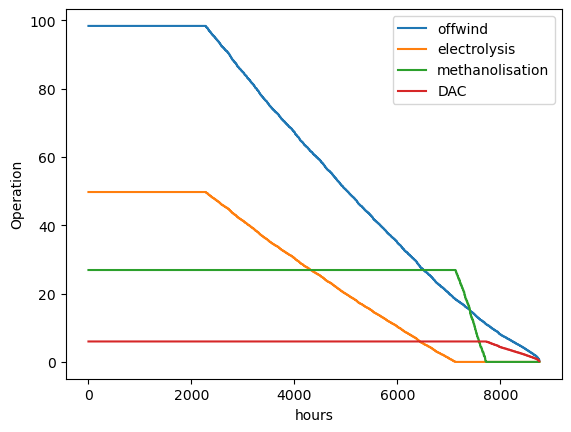

In [34]:
duration_offwind=n.generators_t.p["offwind"].sort_values(ascending=False)
duration_electrolysis=-n.links_t.p1["electrolysis"].sort_values(ascending=True)
duration_methanolisation=-n.links_t.p1["methanolisation"].sort_values(ascending=True)
duration_dac=-n.links_t.p2["DAC"].sort_values(ascending=True)
plt.plot(duration_offwind.values, label='offwind')
plt.plot(duration_electrolysis.values, label='electrolysis')
plt.plot(duration_methanolisation.values, label='methanolisation')
plt.plot(duration_dac.values, label='DAC')
plt.ylabel("Operation")
plt.xlabel("hours")
plt.legend()

In [35]:
(duration_electrolysis/duration_electrolysis.max()).mean()

0.5224902306786894

In [36]:
(duration_methanolisation/duration_methanolisation.max()).mean()

0.8487087885003746

In [37]:
(duration_dac/duration_dac.max()).mean()

0.9458081519881748

**At what cost can the methanol be produced and how does it compare to current methanol price?**

We can calculate the cost ob producing H$_2$ by using the total system cost or averaging the marginal price of the hydrogen bus. 

In [38]:
n.objective / n.loads_t.p_set['methanol demand'].sum()

259.2896868125066

In [39]:
n.buses_t.marginal_price['methanol'].mean()

259.2896868126318

Assuming 5.53 kWh/kg of methanol, 259 EUR/MWh corresponds to  1.43 EUR/kg, while the current price for methanol is around 0.6 EUR/kg (while emitting CO2)

In [41]:
259/1000*5.53

1.4322700000000002